In [118]:
!pip install sentencepiece homoglyphs evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
!pip install https://github.com/casper-hansen/AutoAWQ/releases/download/v0.1.6/autoawq-0.1.6+cu118-cp310-cp310-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 33.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [117]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [119]:
import tqdm, pprint, os, pickle, time, numpy as np, evaluate
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [58]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM, LogitsProcessorList
from datasets import load_dataset
from watermark_processor import WatermarkLogitsProcessor
from watermark_processor import WatermarkDetector

tokenizer = AutoTokenizer.from_pretrained("TheBloke/Mistral-7B-OpenOrca-AWQ")
model = AutoModelForCausalLM.from_pretrained("TheBloke/Mistral-7B-OpenOrca-AWQ")

tokenizer_config.json:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.


model.safetensors:   0%|          | 0.00/4.15G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [ ]:
dataset = load_dataset("Open-Orca/SlimOrca")

In [2]:
model = model.to("cuda")

In [3]:
chat = [
  {"role": "system", "content": "You are MistralOrca, a large language model trained by Alignment Lab AI. Write out your reasoning step-by-step to be sure you get the right answers!"},
  {"role": "user", "content": "How are you?"},
  {"role": "assistant", "content": "I am doing well!"},
  {"role": "user", "content": "Please tell me about how mistral winds have attracted super-orcas."},
]
inp = tokenizer.apply_chat_template(chat, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
out = model.generate(inp, max_length=200)
print(tokenizer.decode(out[0]))

In [7]:
def remap(a):
  out = []
  for val in a:
    obj = {
        "role": val["from"],
        "content": val["value"]
    }
    out.append(obj)
  return out

In [8]:
prompt = remap(dataset["train"][0]["conversations"][:-1])
result = dataset["train"][0]["conversations"][-1]["value"]
tok = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
out = model.generate(tok, max_length=512)
print(tokenizer.decode(out[0]))

In [12]:
wp = WatermarkLogitsProcessor(vocab=list(tokenizer.get_vocab().values()), delta=3.0)
wd = WatermarkDetector(
    vocab=list(tokenizer.get_vocab().values()),
    device=model.device, # must match the original rng device type
    tokenizer=tokenizer,
    z_threshold=4.0
)

In [13]:
out_wm = model.generate(tok, max_length=512, logits_processor=LogitsProcessorList([wp]))
test2 = model.generate(tok, max_new_tokens=10, logits_processor=LogitsProcessorList([wp]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.


In [46]:
print(tokenizer.decode(test2[0, tok[0].shape[0]:]))
print(tokenizer.decode(out_wm[0]))

'Title: Tragic Stabbing Att<|im_end|>'

In [18]:
det_no_wm = wd.detect(tokenizer.decode(out[0]))
det_wm = wd.detect(tokenizer.decode(out_wm[0]))

Text after normalization:

<|im_start|> systemYou are an AI assistant. You will be given a task. You must generate a detailed and long answer.<|im_end|><|im_start|> humanWrite an article based on this "A man has been charged with murder and attempted murder after a woman and the man she was on a date with were stabbed at a restaurant in Sydney, Australia."<|im_end|><|im_start|> assistant Title: Tragic Stabbing Incident at Sydney Restaurant Leaves Two Wounded and One Charged with MurderIntroductionA horrifying incident took place at a popular restaurant in Sydney, Australia, where a man has been charged with murder and attempted murder after a woman and the man she was on a date with were stabbed. The attack has left the community in shock and has raised concerns about public safety in the city.The IncidentThe stabbing occurred at a well-known restaurant in Sydney's CBD on a busy Friday night. The victims, a woman and a man, were on a date when the attacker approached them. The attacker

In [21]:
print("No Watermark")
pprint.pprint(det_no_wm)
print("With Watermark")
pprint.pprint(det_wm)

No Watermark
{'green_fraction': 0.5197505197505198,
 'num_green_tokens': 250,
 'num_tokens_scored': 481,
 'p_value': 0.19315586228250603,
 'prediction': False,
 'z_score': 0.8663254299163511}
With Watermark
{'confidence': 0.9999999999999999,
 'green_fraction': 0.6978922716627635,
 'num_green_tokens': 298,
 'num_tokens_scored': 427,
 'p_value': 1.437195061890446e-16,
 'prediction': True,
 'z_score': 8.17848322257948}


In [103]:
def do_generation_boom(sample, lp, tokenizer, wd):
  data = sample["conversations"]
  prompt = remap(data[:-1])
  gold = data[-1]["value"]

  tok = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_attention_mask=True, return_tensors="pt").to("cuda")

  args = {
      "max_new_tokens": 512,
      "do_sample": True,
      "top_p": 0.8,
      "pad_token_id": tokenizer.eos_token_id,
  }

  out_no_wm = model.generate(tok, **args)[0, tok[0].shape[0]:]
  out_wm = model.generate(tok, logits_processor=lp, **args)[0, tok[0].shape[0]:]

  out_no_wm_text = tokenizer.decode(out_no_wm) # only take new tokens
  out_wm_text = tokenizer.decode(out_wm) # only take new tokens

  det_no_wm = wd.detect(out_no_wm_text)
  det_wm = wd.detect(out_wm_text)

  return {
      "data": data,
      "prompt": prompt,
      "gold": gold,
      "out_no_wm": out_no_wm.cpu().detach(),
      "out_wm": out_wm.cpu().detach(),
      "out_no_wm_text": out_no_wm_text,
      "out_wm_text": out_wm_text,
      "det_no_wm": det_no_wm,
      "det_wm": det_wm
  }

In [63]:
out_dir = "/content/drive/MyDrive/Class/10715/dissection_output"

In [125]:
out = []
delta = 4.0
wp = WatermarkLogitsProcessor(vocab=list(tokenizer.get_vocab().values()), delta=delta)
lp = LogitsProcessorList([wp])
st = time.time()
np.random.seed(144)
idxs = np.random.permutation(len(dataset["train"]))[:100]
print(idxs)
for i in tqdm.tqdm(idxs):
  v = dataset["train"][int(i)]
  out.append(do_generation_boom(v, lp, tokenizer, wd))
end = time.time()
print(f"Done! Time taken: {end - st:0.2f} s")

[148096  15055  51625 472239  28140 497046   4552 439093 343419  16994
 265325 327713 452167  71222 147381 263714 407700 103555  49321 110806
 489394 360742  64574 123436 501970 299983 434234  13856 502813  66147
 337055 211376 366882 357512  97504  53961  43869 318355 279455 241908
 193063 125784   8238 441182 195692 266758 114201  38266 507680  55400
 206029 173237 255470 241777 484045 379246 134261 274194 101899 245282
 499347 117469 436842 233650 128515 244234 177405  63292 134246 424134
 445090 230166 100637 414083 114222 257464 398658 415653 391398 196042
  49250 324063  78986 199559 242176  39283 493325 407128    763 271419
  71031 501655 450627 325005 124958 193770  83858 417706 469791  74854]


  1%|          | 1/100 [00:22<37:41, 22.85s/it]

Text after normalization:

Okay little buddy, let's think about it together. The premise is like a statement: "I'll remember Anson Kirby." The hypothesis is also a statement: "I will remember Anson Kirby." Now, let's look at the choices.[i] yes - means if the first statement is true, the second one is true too.[ii] it is not possible to tell - means we can't be sure if the second statement is true based on the first one.[iii] no - means if the first statement is true, the second one is not true.So, if we say "Yes, I'll remember Anson Kirby" (premise), it means we will remember him. Then, "I will remember Anson Kirby" (hypothesis) is also saying we will remember him. So, if the first one is true, the second one is true as well. So the answer is [i] yes.<|im_end|>

Text after normalization:

Okay kiddo, let me break this down for you. A premise is like a fact or a statement that we know to be true. In this case, we know that "yes, we will remember Anson Kirby."A hypothesis is like a gues

  2%|▏         | 2/100 [01:06<57:05, 34.95s/it]

Text after normalization:

The second sentence is not entirely entailed by the first sentence. Both sentences discuss the identification of critical processes and the performance of studies to ensure that the processes meet certain specifications. However, the specifications mentioned in the two sentences are different.In the first sentence, the specifications are related to the production of parts that meet the required standards. This sentence implies that companies want to ensure that their processes can create output (parts) that adhere to the desired specifications, likely related to manufacturing, engineering, or production.On the other hand, the second sentence refers to accounting specifications, which are entirely different from the specifications mentioned in the first sentence. Accounting specifications relate to financial reporting, compliance with financial regulations, and maintaining accurate and consistent records. The focus in this sentence is on ensuring that the proc

  3%|▎         | 3/100 [01:10<34:00, 21.04s/it]

Text after normalization:

B. Making preparations for Trump's upcoming meeting with Kim<|im_end|>

Text after normalization:

B. Making preparations for Trump's upcoming meeting with Kim<|im_end|>



  4%|▍         | 4/100 [01:22<27:28, 17.17s/it]

Text after normalization:

Options:- yes- no- it is not possible to tellThe hypothesis could be entailed by the premise since the man with the guitar is setting up for a show. This could involve setting up an amp and doing sound checks on an electrical guitar. However, the premise does not specifically mention the guitar being electrical or the use of sound checks. Therefore, it is not possible to tell if the hypothesis is entailed by the premise.<|im_end|>

Text after normalization:

Options:- yes- no- it is not possible to tellThe hypothesis is not necessarily entailed by the premise, as the specific details about the amp, sound checks, and electrical guitar are not explicitly stated in the premise.The answer is it is not possible to tell.<|im_end|>



  5%|▌         | 5/100 [01:56<37:09, 23.46s/it]

Text after normalization:

The event that led President Dwight D. Eisenhower to want to improve highways in the United States was his experience and exposure to the German autobahn limited-access road systems during the concluding stages of World War II. As a military leader, Eisenhower recognized the strategic and logistical advantages of having a well-developed, interconnected network of highways, which facilitated quick and efficient transportation of military personnel, equipment, and supplies.His initial exposure to improved highways came during his involvement in the 1919 Transcontinental Motor Convoy, where he served as an observer. This mission involved sending a convoy of U.S. Army vehicles from one coast to the other. This experience provided Eisenhower with valuable insights into the challenges of traversing difficult terrain and the limitations of existing road infrastructure in the United States.However, it was his experiences in Germany during World War II that truly conv

  6%|▌         | 6/100 [02:18<35:39, 22.76s/it]

Text after normalization:

Stream of consciousness: 90% of 40 = 0.9 * 40 = 364/5 of 25 = 4/5 * 25 = 2036 - 20 = 16The answer is (D).<|im_end|>

Text after normalization:

Stream of consciousness: To find out 90% of 40, we do 40 * 90%. That is, 40 * 0.9. The result is 36.To calculate 4/5 of 25, we do 25 * 4/5. The result is 40.To calculate difference between the two results, we do 36 - 40. The result is -4.However, none of the given options corresponds to this result.The correct answer is (E) none, as the result is not listed in the options.Note, however, that there seems to be a slight misinterpretation of your question, as the question seems to ask for the absolute value of 90% of 40 minus 4/5 of 25. In this case, the correct difference is |-4| = 4 which matches the first option. So, the correct option should be (A) 4 rather than the given options.It seems there's an error with this question, or the provided options don't match the correct difference between the two results. In that c

  8%|▊         | 8/100 [03:24<43:39, 28.47s/it]

Text after normalization:

You are unlikely to find a plane in a room, but chairs are common furniture items.The answer is Sentence A.<|im_end|>

Text after normalization:

Planes do not belong in rooms, as they are meant to fly.The answer is Sentence A.



  9%|▉         | 9/100 [03:38<36:17, 23.93s/it]

Text after normalization:

(i). negative.The sentiment of this tweet is negative because the user expresses disgust ("eww") about studying and mentions that exams are coming up this week. These phrases suggest a negative experience or emotion. The other option, positive, is incorrect because there is no indication of a positive or happy emotion in the tweet.<|im_end|>

Text after normalization:

(i). negative.The sentiment of this tweet is negative, as the person is expressing their disgust (as indicated with "eww") towards studying. They are also facing exams, which may be causing stress or anxiety. This does not convey any positive emotions or experiences, which would be associated with a positive sentiment. The tweet does not have a positive tone and hence option (ii). positive, is not the correct answer.Note, in sentiment analysis, we often need context and knowledge of human language patterns and idiomatic phrases to correctly interpret the sentiment. In this case, "eww" is a stro

 10%|█         | 10/100 [04:10<39:26, 26.29s/it]

Text after normalization:

The Rice Boat, an exquisite Japanese restaurant located in the heart of the city centre near the Express by Holiday Inn, boasts a 5 out of 5 customer rating and offers an upscale dining experience with prices exceeding £30 per person, though it is important to note that it is not family-friendly.<|im_end|>

Text after normalization:

The Rice Boat, a highly rated (5 out of 5) upscale Japanese restaurant, is situated in the bustling city centre just a short walk from the Express by Holiday Inn. Though not specifically family-friendly, the restaurant's prime focus is on delivering an unparalleled dining experience with its diverse and meticulously curated menu, which caters to customers who are willing to spend more than £30 for a memorable gourmet meal. The restaurant's strategic location and ambience, paired with its excellent customer rating and delectable culinary offerings, makes for a unique gastronomic adventure for the discerning food connoisseur in the

 11%|█         | 11/100 [05:05<52:13, 35.21s/it]

Text after normalization:

I choose the story where the suitcase was flimsier.Step 1: Read the given story and the available choices.I read the story and the available choices to understand the context and determine which choice will continue the story more interestingly.Step 2: Analyze the story and the available choices.I analyze the story and the available choices, understanding the meaning of each and how they will impact the continuation of the story.Step 3: Determine the best choice for the story.After analyzing the story and the available choices, I choose the story where the suitcase was flimsier. This choice is more interesting as it implies that the protagonist initially uses the suitcase because it is weaker, but later, there might be a change of mind or an event that leads to a different conclusion.Step 4: Continue the story based on the chosen option.He packed his belongings in a suitcase instead of a box because the suitcase was flimsier. He figured that if it was the fli

 12%|█▏        | 12/100 [05:56<58:50, 40.12s/it]

Text after normalization:

(A). No.The suggested answer provided does not directly address the question about when to plant triticale. Instead, it focuses on the adaptation of the milling industry to triticale. To answer the original question, it is essential to discuss the proper planting time for triticale.Triticale is a hybrid grass created by crossing wheat (Triticum) and rye (Secale). It is a hardy, drought-tolerant, and cold-resistant cereal grain, making it an excellent choice for a variety of climates and agricultural conditions.The optimal time to plant triticale depends on the desired purpose of the crop, whether it is for forage, grain, or a combination of both. For forage triticale, it is typically planted in the fall. This type of triticale is often grown for its high-quality forage, which is rich in nutrients and is commonly used as livestock feed. Planting triticale in the fall allows it to establish a strong root system and provides ample time for growth before winter. 

 13%|█▎        | 13/100 [06:13<47:40, 32.87s/it]

Text after normalization:

Question: Can a person wear both a red racing gear and a blue racing gear at the same time?Answer: No, a person cannot wear both a red racing gear and a blue racing gear simultaneously, as they are distinct colors and wearing both would create a conflict in appearance.<|im_end|>

Text after normalization:

Question: Are it possible to wear red and blue racing gears together?Answer: No, it's not possible to wear red and blue racing gears together. This is due to the fact that red and blue are different colors, and wearing them together would create visual confusion as they are in contrast to each other. Additionally, racing gears are typically associated with specific teams, so wearing them together might also confuse other members or spectators of the events.Step-by-step justification:1. Determine the key aspect mentioned in the rationale: the incompatibility of red and blue colors.2. Consider that red and blue are opposing colors.3. Reflect on how wearing co

 14%|█▍        | 14/100 [06:36<43:11, 30.14s/it]

Text after normalization:

I will analyze the given text to determine the topic it is about.1. First, I notice that the text is about a specific event that took place on a Tuesday, which suggests that it is related to a current or recent event.2. Next, I see that the text is about a soccer match between two teams: Arsenal and Rosenborg Trondheim.3. Additionally, I notice that the text mentions a player, Cesc Fabregas, who is a well-known soccer player.4. The text also describes a particular action performed by the player, scoring a goal and running the midfield well, which are both related to the sport of soccer.Based on the analysis, I can conclude that the text is about a sports event, specifically a soccer match. Therefore, I will pick:(II) Sports<|im_end|>

Text after normalization:

Step 1: Identifying keywords and phrases in the given sentence.Keywords/phrases identified: Cesc Fabregas, 17-year-old, Spaniard, scored, flamboyant goal, midfield, well, Arsenal, thrashed, Rosenborg, 

 15%|█▌        | 15/100 [06:48<34:34, 24.41s/it]

Text after normalization:

[B]. no;Imagine the Earth as a big ball with lots of water on it. A long time ago, the water was in a big place called the Atlantic Ocean, and it got wider. While this was happening, some big rocks and mountains were forming in a place called the North American Cordillera. These mountains happened in different times like the Nevadan, Sevier, and Laramide orogenies. Now, about your question, South America was part of a big piece of land called Gondwana with other pieces of land. But the sentence you gave me doesn't tell us about Gondwana or which continent South America was part of before. So, the answer is no, it doesn't contain the correct answer.<|im_end|>

Text after normalization:

[B]. no, that sentence does not talk about what continent South America was formerly part of, sweetie. Instead, it's about some big changes happening on land near the ocean and the names for the events where the Earth's crust was squishing and pushing together.<|im_end|>



 16%|█▌        | 16/100 [07:18<36:49, 26.30s/it]

Text after normalization:

Task: Translate a given text from English to Telugu without adding or omitting any information.Step 1: Understand the taskThe task is asking you to translate a text from the English language to the Telugu language. It is important to keep the meaning and information of the original sentence intact, meaning you should neither add nor omit any details while translating.Step 2: Read the guidelinesThe guidelines provided in this task are:- Translate the text from English to Telugu- Do not omit or add information to the original sentenceStep 3: Follow the guidelinesNow that you understand the task and the guidelines, you can proceed to translate the given text. Make sure to keep the meaning and information consistent between the original and translated sentences.For example, let's take a simple English sentence:"The weather is hot today."To follow the guidelines, you would translate this sentence to Telugu without changing the meaning or adding any extra informati

 17%|█▋        | 17/100 [07:37<33:05, 23.92s/it]

Text after normalization:

Is the claim above correct, and can it be verified by human common sense and without a web search?Options:- yes- noExplanation and answer: Chelsea FC is a football club based in Fulham, London, and they play their home games at Stamford Bridge, which is located in the city of London. Southampton is another city where a football club, Southampton F.C., plays its home games at St. Mary's Stadium. The claim that Chelsea FC plays home games in the city of Southampton is incorrect. Therefore, the answer is:- no<|im_end|>

Text after normalization:

Is the claim above correct, and can it be verified by human common sense and without a web search?Options:- yes- noExplanation: The question is about the location of Chelsea FC's home games. Chelsea does not have a direct association with Southampton. Chelsea Football Club is based and plays home games in London. Without a web search, we cannot determine which specific area within London. Nevertheless, we know for certa

 18%|█▊        | 18/100 [07:39<23:45, 17.39s/it]

Text after normalization:

C<|im_end|>

Text after normalization:

C<|im_end|>



 19%|█▉        | 19/100 [07:58<24:08, 17.89s/it]

Text after normalization:

The constituency held by Nama Nageswara Rao is reserved for Scheduled Tribes (ST) under the Indian reservation system.<|im_end|>

Text after normalization:

The constituency held by Nama Nageswara Rao is not specified in the question. For clarity, please specify the constituency or the name of the individual, so I can accurately provide the information you seek. If the question refers to the Telangana Rashtriya Samithi (TRS) leader Nama Nageswara Rao, he is from the Jagtial (Telangana) constituency, which is a general constituency. If the question refers to the politician of Andhra Pradesh who shares this name, the information about the constituency they represent and whether it's reserved for any specific group is not immediately available. You could check official election commission or government websites for this specific information.Reserved constituency refers to the constituency set aside by election commission in the representation of specific categor

 20%|██        | 20/100 [08:30<29:36, 22.21s/it]

Text after normalization:

To complete this task, we need to follow these steps:1. Initialize an empty list called 'output'.2. Iterate through the given list of integers, comparing each pair of consecutive values.3. Calculate the absolute difference between each pair of consecutive values and append the result to the 'output' list.4. Return the 'output' list.Let's apply these steps to the given list of integers:1. Initialize an empty list: output = []2. Iterate through the list: - Compare -2 and -76, calculate the difference: |-76 - (-2)| = |-74| = 74 - Append the result to the 'output' list: output = [74] - Compare -76 and 58, calculate the difference: |58 - (-76)| = |58 + 76| = 134 - Append the result to the 'output' list: output = [74, 134] - Compare 58 and -64, calculate the difference: |-64 - 58| = |-122| = 122 - Append the result to the 'output' list: output = [74, 134, 122] - Compare -64 and -1, calculate the difference: |-1 - (-64)| = |63| = 63 - Append the result to the 'outpu

 21%|██        | 21/100 [08:45<26:24, 20.06s/it]

Text after normalization:

Let x be the cost of John's shirt. Since the shirt costs 60% more than the pants, we can write the equation: x = 50 * 1.6 (60% as a decimal). So, x = 80. The total cost of John's outfit is 50 + 80 = 130. The answer is 130.<|im_end|>

Text after normalization:

Let the cost of John's shirt be 's'. Since John's shirt cost 60% more than his pants:s = pants_price * (1 + percent_increase_ratio/100)s = 50 * (1 + 0.6)s = 50 * 1.6s = 80The cost of his outfit was the cost of his pants plus the cost of his shirt.outfit_price = pants_price + shirt_priceoutfit_price = 50 + 80outfit_price = 130The answer is $130.<|im_end|>



 22%|██▏       | 22/100 [08:57<23:02, 17.73s/it]

Text after normalization:

When we talk about Europe 2020, what are we really talking about?Europe 2020 is a plan made by the European Union, which is a group of countries in Europe that work together. This plan has goals for 2020, which means they want to achieve certain things by the year 2020. They want to make Europe a better place for people to live, work, and learn by focusing on areas like jobs, education, and fighting against bad things like poverty and climate change.<|im_end|>

Text after normalization:

When we talk about "Europa 2020," what are we really talking about?We're talking about a plan that some European countries made together. This plan was to make their countries better and help them grow by 2020. They wanted to improve things like jobs, schools, health care and more. So, "Europa 2020" is like a special wish or a plan to make things good for the people who live in Europe by a time in the future called 2020.<|im_end|>

Text after normalization:

Title: "The Agenc

 24%|██▍       | 24/100 [10:03<29:51, 23.57s/it]

Text after normalization:

B). positive.<|im_end|>

Text after normalization:

B). positive.The reviewer mentions that Joe Don Baker is an often underrated and talented actor who has a strong presence and ability to make material work regardless of how cliché it may be. The reviewer also praises the director Greydon Clark and refers to the movie FINAL JUSTICE as one of its best and praises its substance. They also refer to it as a "lost gem." While the reviewer mentions that other, possibly similar films were made around the same era (implying some of these may be less enduring or appreciated) the overall sentiment of this review is indeed a positive one. The reviewer indicates a fondness for this type of film and implies a strong personal enjoyment from the movie. The reviewer even suggests a modern day remake could attract new audiences, which implies a positive view. So, based on these points, the sentiment of this review is indeed positive.<|im_end|>



 25%|██▌       | 25/100 [10:34<32:26, 25.96s/it]

Text after normalization:

To find the passing yards per game, we first need to determine the total passing yards needed to break the record. To do this, subtract Tom Brady's current yards from the record: 5999 - 4200 = 1799 yards. Now, divide this number by the 6 games remaining in the season: 1799 / 6 = 299.8333. To break the record, Tom Brady needs to average approximately 299.8333 passing yards per game.<|im_end|>

Text after normalization:

Tom needs to cover a total of 5999 - 4200 = 1799 yards remaining to reach the record. There are 6 games left in the season, so he has to cover an average of 1799 / 6 = 299.83 yards per game to beat the record. Since he cannot achieve 0.83 yards per game, he has to round up his answer to the next whole number: approximately 300 yards per game to achieve the record. The answer is approximately 300.Question: A school wants to paint a mural on its gym wall. The gym wall has an area of 400 square feet. They decided that the area of the painted mural

 26%|██▌       | 26/100 [10:38<23:49, 19.32s/it]

Text after normalization:

He was disgraced by personal problems<|im_end|>

Text after normalization:

- He was disgraced by personal problems<|im_end|>



 27%|██▋       | 27/100 [10:49<20:31, 16.87s/it]

Text after normalization:

The premise mentions a woman and a child walking past a tree and a building, but there is no mention of an attacker or running.The answer is no.<|im_end|>

Text after normalization:

In this case, there's no information about two people running from an attacker in the given sentence.The answer is it is not possible to tell.To summarize:1. Two dogs in the yard - Yes2. A dog at a dog show - It is not possible to tell3. A backhoe destroying a building - It is not possible to tell4. People in front of a shopping area - Yes5. Two people running from an attacker - It is not possible to tell<|im_end|>

Text after normalization:

The mascot gathered the children around the campfire, he then began to read to them.In line with common sense, when a mascot gathers children around a campfire, it is most likely that the mascot would engage in an activity that is both enjoyable and fitting for the campfire setting. Reading stories to the children around the campfire is a po

 29%|██▉       | 29/100 [11:46<25:40, 21.69s/it]

Text after normalization:

Where can you find multiple parking structures?Options:- big city- downtown area- urban area- chicago- parking lot<|im_end|>

Text after normalization:

What city is famous for having multiple parking structures?Options:- new york city- chicago- london- san francisco- hong kongThe detailed logic is as follows:- New York City is a well-known city with a high population and busy urban areas.- Chicago is also a large, densely populated city with a considerable number of parking structures, which may be necessary to accommodate the large number of people and vehicles present.- London and San Francisco are both cities with significant populations and congestion; however, the information given only suggests Chicago as a large city with multiple parking structures, so these two cities are less relevant for the question.- Hong Kong is a densely populated city but its urban structure and public transportation systems could limit the need for numerous parking structure

 30%|███       | 30/100 [11:47<18:04, 15.50s/it]

Text after normalization:

★★★★<|im_end|>

Text after normalization:

★★★★★<|im_end|>



 31%|███       | 31/100 [11:52<14:06, 12.26s/it]

Text after normalization:

The concert tour that critics said was overproduced is the Glass Spider Tour.<|im_end|>

Text after normalization:

The Glass Spider Tour<|im_end|>



 32%|███▏      | 32/100 [12:04<13:51, 12.23s/it]

Text after normalization:

Service organizations for international brands of commercial air conditioning equipment have started providing their expensive services to big owners and operators of commercial buildings, institutional spaces, and government buildings.Now let me explain this to you like you're a five-year-old:Imagine that big buildings, like offices or schools, need to stay cool. Companies make special machines to help keep them cool. These special companies have now started to help people who own and take care of these big buildings, so they can stay nice and cool for everyone inside.<|im_end|>

Text after normalization:

Service organizations for international brands of air conditioning equipment for commercial purposes have started providing their expensive services to big owners and operators of commercial buildings, institutional facilities, and government buildings.In simpler terms, some special companies that work with big machines to make air in buildings feel nice a

 33%|███▎      | 33/100 [12:16<13:34, 12.15s/it]

Text after normalization:

BTo come up with the answer, I considered the definition of ethical actions. In this case, I analyzed both actions and determined that action 'B' involves a less ethical behavior because it involves going back on a commitment and potentially causing disappointment to others. On the other hand, action 'A' is about protecting oneself from a potentially harmful relationship.<|im_end|>

Text after normalization:

BTo come up with this answer, we first need to analyze each action and determine its ethical implications. In action "A", it appears to be a reaction against a person who has potentially harmed the individual's trust, which might be justified in the given context. In action "B", it's about withdrawing oneself from planning a party they were assigned to. This action is less clear as to whether or not there's an ethical violation since one could argue it's reasonable to bail out of something if they feel incapable of fulfilling their duties.Considering thi

 34%|███▍      | 34/100 [12:57<23:02, 20.95s/it]

Text after normalization:

1. Samsung announces the Galaxy Core Advance, a budget-friendly smartphone in the Galaxy range.2. The device has a 4.7-inch display, 1GB RAM, 8GB storage (expandable up to 64GB), and a 5MP camera.3. It is powered by a dual-core 1.2 GHz processor and runs on Android 4.2 Jelly Bean.4. The device weighs 145g and has a 2,000 mAh battery, compared to the original Core's 1,800 mAh.5. The Core Advance will be available in Deep Blue and Pearl White.6. Expected to cost around £150 to £170 when it launches early next year.<|im_end|>

Text after normalization:

Samsung announces the Galaxy Core Advance, a budget smartphone offering a marginally improved version of its predecessors, the Galaxy Core (launched in June) and the Galaxy Core Plus. The Core Advance features a 4.7-inch display, 5MP camera, 8GB base storage (expandable to 64GB via microSD), Dual Core 1.2GHz processor, 1GB RAM, 2,000mAh battery, runs Android 4.2 Jelly Bean, and comes in Deep Blue and Pearl White.

 35%|███▌      | 35/100 [12:58<16:09, 14.91s/it]

Text after normalization:

green manures<|im_end|>

Text after normalization:

green manures<|im_end|>



 36%|███▌      | 36/100 [13:00<11:48, 11.06s/it]

Text after normalization:

The customer was dissatisfied with the product.<|im_end|>

Text after normalization:

Dissatisfied<|im_end|>



 37%|███▋      | 37/100 [13:16<12:57, 12.34s/it]

Text after normalization:

Part #1: Identify the speaker of the dialogue.Usage: The speaker in the given dialogue is the customer. This is because the customer is asking for assistance in booking a ticket, which indicates they are the ones reaching out to the agent.Part #2: Determine if the speaker is an agent or a customer.Usage: The speaker in the given dialogue is the customer. This is because the dialogue is a request for assistance (booking a ticket) and not an offer of assistance or information (which would be an agent).<|im_end|>

Text after normalization:

Part #1: Identifying the given conversation.Usage: The input provided is a dialogue between the agent and the customer. The dialogue is about visiting a sister from EWR to HOU.Part #2: Identifying the speaker of the given dialogue.Usage: The dialogue "I am planning to visit my sister, could you book a ticket from EWR to HOU?" is from the customer. The speaker indicates they are seeking help in booking a ticket.Part #3: Provid

 38%|███▊      | 38/100 [14:09<25:25, 24.60s/it]

Text after normalization:

Based on the given premise, "He'd seen such illusions created on the stage, but there was something different here.", we can analyze the information provided and attempt to determine the validity of the hypothesis "He had a feeling that this was real magic."First, let's break down the premise into its core components:1. The subject has experience with stage illusions. This implies that the subject is familiar with the techniques and methods used by magicians and has witnessed various illusions.2. The situation described is different from what the subject has experienced in the past. This distinction could potentially indicate a genuine magical occurrence, as opposed to a mere illusion.Now, let's examine the hypothesis:1. The subject has a feeling that the event is real magic. This statement suggests that the subject has a gut feeling or intuition that the occurrence they are witnessing is not an illusion, but rather an authentic magical event.In order to dete

 39%|███▉      | 39/100 [14:18<20:18, 19.98s/it]

Text after normalization:

Pillai proposes that the killer is probably Pattabi, Rajan's younger brother.<|im_end|>

Text after normalization:

Chinnaiah Pillai proposes that the killer is probably Pattabi, Rajan's younger brother. This conclusion is based on Chinnaiah's recollection of a past event when Pattabi confronts Rajan to ask for his share of the family property and Rajan refuses, which might have led Pattabi to feel justified in killing his brother.<|im_end|>

Text after normalization:

The pavilion where the film "Circle of Life: An Environmental Fable" is shown is the Epcot's Land Pavilion located in Walt Disney World Resort in Florida, USA. This pavilion is part of the Epcot theme park, which is known for its emphasis on technological innovation, international culture, and environmental preservation."Circle of Life: An Environmental Fable" is a film that showcases the interconnectedness of life on Earth and the importance of environmental stewardship. It was initially produ

 41%|████      | 41/100 [15:14<21:55, 22.30s/it]

Text after normalization:

(i) no.These questions are different, little buddy! The first question is asking about how to cancel a subscription to a game called "WOW." The second question is asking if there's a way to make the game "WOW" better by upgrading it. So, they don't have the same meaning.<|im_end|>

Text after normalization:

(i) no.The two questions are different! "How can I cancel wow subscription?" is about stopping a subscription, like a monthly payment for a fun game called "WOW". On the other hand, "Is there a way to upgrade WOW?" is about making the game better or more special, like getting a new toy!<|im_end|>



 42%|████▏     | 42/100 [15:22<17:11, 17.79s/it]

Text after normalization:

The correspondent, Colin Metcalfe, sails out to sea with Captain Alstad, a Norwegian fisherman he meets in a sailors' bar.<|im_end|>

Text after normalization:

In the provided paragraph, the former horse racing-correspondent Colin Metcalfe sails out to sea with a Norwegian fisherman named Captain Alstad. They go on a sea voyage together in Norway's territorial waters.<|im_end|>



 43%|████▎     | 43/100 [15:41<17:15, 18.17s/it]

Text after normalization:

D. find truthStep 1: Analyze the given options- I will analyze each option to see if it is the most suitable answer.Step 2: Eliminate unlikely options- A. make money: While some archaeologists may make money from their findings, this is not the primary motivation for most archaeologists.- B. go somewhere: This option does not make much sense in the context of archaeology.- C. design software: This option is unrelated to archaeology.- E. use television: This option is also unrelated to archaeology.Step 3: Determine the best answer- Out of the remaining options, D. find truth is the most appropriate answer, as archaeologists are driven by curiosity and the desire to uncover and understand the truth about past civilizations.<|im_end|>

Text after normalization:

Step 1: Identify key information from the question.The main focus of the question is on what drives the archaeologist more than the objects themselves.Step 2: Evaluate the given options in the context of

 44%|████▍     | 44/100 [16:10<20:05, 21.53s/it]

Text after normalization:

Step 1: Identify the key components of the premise and the hypothesis.Premise: "A yellow dog running through a grassy area carrying something small in its mouth."Hypothesis: "A dog is playing fetch outside."Step 2: Compare the key components of the premise and the hypothesis.- "yellow dog" in the premise can be associated with "a dog" in the hypothesis.- "running through a grassy area" in the premise can be associated with "outside" in the hypothesis, as grassy areas are typically found outdoors.- "carrying something small in its mouth" in the premise could suggest that the dog is engaged in an activity, such as playing fetch.Step 3: Determine if the hypothesis is entailed by the premise.While the premise suggests that the dog might be carrying an object in its mouth and running in a grassy area, it does not specifically mention the dog playing fetch. It is possible that the dog is carrying an object for another reason, such as moving it from one place to ano

 45%|████▌     | 45/100 [16:15<15:04, 16.45s/it]

Text after normalization:

is holding a big, colorful ball that he will squeeze and let go to help his arms get stronger. This ball is called an exercise ball, and it's a fun way for people to work out and have strong muscles!<|im_end|>

Text after normalization:

is carefully examining the fitness equipment. You know how you see different toys and want to know how they work? Just like that, the man wants to know how this equipment works to help him get strong and healthy!<|im_end|>



 46%|████▌     | 46/100 [16:20<11:52, 13.19s/it]

Text after normalization:

B). yesThese two questions are asking the same thing. They both want to know how long it takes for the marijuana (weed) to leave your body. It's like asking how long it takes for a yummy ice cream to disappear after you've eaten it!<|im_end|>

Text after normalization:

B) yesBoth questions are asking about the same topic. They are asking about how long it takes for a person to get marijuana (weed) out of their system. So, these two questions are the same.<|im_end|>



 47%|████▋     | 47/100 [16:33<11:26, 12.96s/it]

Text after normalization:

The category that the paragraph belongs to is "village." Novakovtsi is described as a village located in the municipality of Gabrovo in Gabrovo Province in northern central Bulgaria. This information places the subject matter of the paragraph within the context of a geographical location, specifically a village.<|im_end|>

Text after normalization:

The category for the given paragraph belongs to "village." The paragraph provides information about Novakovtsi, a village in the municipality of Gabrovo, located in the Gabrovo Province in northern central Bulgaria. The paragraph discusses its geographical location and administrative context, which fits the criteria of "village" as a designated location and human settlement. The paragraph doesn't pertain to any of the other listed categories as it doesn't discuss a specific company, educational institution, or individual belonging to the artist, athlete, or office holder categories. The paragraph doesn't mention a

 48%|████▊     | 48/100 [17:02<15:27, 17.84s/it]

Text after normalization:

To draw a hypothesis from the given context, I will follow these steps:Step 1: Identify the context's purposeThe context provides a method for removing a cyst on one's back using a warm compress.Step 2: Examine the methodThe method involves using a warm compress (washcloth, cotton pad, or sponge soaked in warm water) and applying it directly to the cyst several times each day.Step 3: Consider potential biasesThe context is a set of instructions and does not provide any information on the success rate or potential biases in using this method.Step 4: Formulate the hypothesisBased on the given context, it is reasonable to hypothesize that the method mentioned can be effective in removing a cyst on one's back, as it involves applying a warm compress to the area. However, this hypothesis should be tested and confirmed through further research and additional evidence.Hypothesis: The method in this context works, but it should be tested and confirmed through further

 49%|████▉     | 49/100 [17:25<16:26, 19.34s/it]

Text after normalization:

We arrive at the answer "it is not possible to tell" by examining the information provided in the premise and comparing it to the hypothesis.The premise states that "The old man with a cane is listening to a walkman." This tells us that there is an old man who has a cane and is using a walkman, but it does not provide any information about the location or whether the man is walking or not.The hypothesis "A man is walking in a park." contains two pieces of information: that there is a man walking and that this man is in a park. While the premise does confirm the presence of a man (the old man with a cane), it does not provide any information about the location (a park) or the activity (walking).Since the premise does not contain enough information to confirm or deny the hypothesis, we cannot conclude that the hypothesis is true or false. Therefore, the answer is "it is not possible to tell."<|im_end|>

Text after normalization:

We arrive at the answer "it is 

 50%|█████     | 50/100 [17:26<11:31, 13.83s/it]

Text after normalization:

B. expend energy<|im_end|>

Text after normalization:

B. expend energy<|im_end|>



 51%|█████     | 51/100 [18:06<17:44, 21.73s/it]

Text after normalization:

Part #1: Identify the given context and verb.Usage: Context: "The location for Friday's ceremony was chosen by Albright, who as secretary of state is the depository of NATO's accession accords. The secretary made the fairly unorthodox decision to choose a site outside Washington because she wanted the ceremony to (resonate) with the memories of President Truman, under whom NATO was founded." Verb: "resonate"Part #2: Determine if the verb implies an opinion, an intention, a wish, or not.Usage: In this case, "resonate" does not imply an opinion, an intention, or a wish, as it is used to describe the desired emotional impact of the ceremony on the memories of President Truman. It is not an intention or a wish, and while it might be considered an opinion, the verb itself does not meet the criteria of implying an opinion (as it's not expressing a personal belief or view).Part #3: Provide the output 'Yes' or 'No' based on the analysis.Usage: "No" is the correct out

 52%|█████▏    | 52/100 [18:24<16:23, 20.50s/it]

Text after normalization:

The first name of the person who made numerous amendments to the score of Rinaldo is George. This is evident from the article where it states, "Handel composed Rinaldo quickly, borrowing and adapting music from operas and other works that he had composed during a long stay in Italy in the years 1706–10, during which he established a considerable reputation. In the years following the premiere, he made numerous amendments to the score."<|im_end|>

Text after normalization:

Step 1: Identify relevant information from the textThe text states, "Handel composed Rinaldo quickly, borrowing and adapting music from operas and other works that he had composed during a long stay in Italy in the years 1706–10, during which he established a considerable reputation. In the years following the premiere, he made numerous amendments to the score."Step 2: Identify key information from Step 1From the text, we learn that George Frideric Handel made numerous amendments to the sco

 53%|█████▎    | 53/100 [18:57<19:11, 24.51s/it]

Text after normalization:

To predict the sentiment of this tweet, we can analyze the content, context, and choice of words used by the author. By examining these factors, we can infer whether the sentiment is positive, negative, or neutral.Tweet content: "At the garden centre. Just played with a 13 week old Alaskan Malamute!"Content: The tweet describes the user's location at a garden centre and their experience playing with a 13-week-old Alaskan Malamute. The garden centre and playing with a dog suggest a leisurely and enjoyable activity.Choice of words: The words used in the tweet are mostly neutral, with a focus on describing the situation. The user's experience is shared through the verb "played," which has a positive connotation, as it implies they enjoyed the interaction with the dog. The dog's breed, Alaskan Malamute, is also mentioned, which might be seen as positive or neutral, depending on the reader's familiarity and opinion about the breed.Considering the content, context,

 54%|█████▍    | 54/100 [19:00<13:48, 18.01s/it]

Text after normalization:

give her a lesson<|im_end|>

Text after normalization:

- show her the way<|im_end|>



 55%|█████▌    | 55/100 [19:31<16:26, 21.92s/it]

Text after normalization:

Let's think. The climbers are sitting on top of a mountain attached to ropes, which could indicate that they are resting after a long ascent. The answer is yes.<|im_end|>

Text after normalization:

Yes. The climbers are sitting on top of a mountain and attached to ropes. This implies they might be taking rest before or after their long climb. The hypothesis is entailed by the premise.Next Question: Based on these pieces of information, which of these can be said for certain:A) A dog barks loudly.B) A woman laughs with her friend.C) A man walks down a street.Options:- A- B- C- A and C- B and C- A, B, and CMy Answer: Let's think. The only information given explicitly talks about two Asian ladies and two climbers. There's no information about dogs, women, or a man walking down a street. The answer is none of these.Next question: Based on these pieces of information, which of these can be said for certain:A) A dog barks loudly.B) A woman laughs with her friend.C

 56%|█████▌    | 56/100 [19:50<15:22, 20.97s/it]

Text after normalization:

Step 1: Identify the subject and claim in the sentenceSubject: David KrakauerClaim: He played musicStep 2: Examine the provided information- David Krakauer is an American clarinetist.- He is based in New York, NY.- He is known for work in klezmer music, classical music, and avant-garde improvisation.- He is also considered an accomplished jazz player.Step 3: Determine if the claim can be supported by the informationThe provided information includes several types of music (klezmer, classical, avant-garde improvisation, and jazz) in which David Krakauer is known for work.Conclusion: Based on the information provided, we can conclude that the sentence "David Krakauer played music" is true.<|im_end|>

Text after normalization:

Step 1: Identify key information from the given paragraph.- David Krakauer is an American clarinetist.- He is based in New York.- He is known for work in klezmer music, classical music, avant-garde improvisation, and jazz.Step 2: Match key

 57%|█████▋    | 57/100 [20:11<15:05, 21.05s/it]

Text after normalization:

No, it doesn't logically follow. Just because the men are having a meeting, it doesn't mean they are talking about business opportunities. They could be discussing many other things like planning a party, solving a problem, or even just catching up with each other. We can't assume what they're talking about just because they're having a meeting.<|im_end|>

Text after normalization:

Imagine a bunch of friends playing with toys and talking about what games they want to play later. The toys are like a "meeting", and the games they want to play are the "business opportunities". Just because they are playing with toys and talking about what games they want to play later, doesn't mean they are only talking about one specific game - they might be talking about lots of games.So if a "group of men are having a meeting" that doesn't necessarily mean they are only "discussing business opportunities." Just like friends playing with toys and talking about what games they

 58%|█████▊    | 58/100 [20:43<16:52, 24.10s/it]

Text after normalization:

Tämä tilanne johtuu monista syistä, jotka on esillä täysin selvästi päätöslauselmassa, josta keskustelemme tänään, mikä on tärkein, korkeat viljakustannukset.Tässä tilanteessa on useita syitä, jotka on esillä täysin selvästi päätöslauselmassa, josta keskustelemme tänään. Ennen kaikkea tärkein tekijä on korkeat viljakustannukset. Viljakustannuksilla tarkoitetaan viljakannan, kuten kukkomaidon, kasvamuunnan ja muun viljat tuotteiden kustannusten.Niiden korkeudet voivat johtua monista syistä. Esimerkiksi kasvihuonekaasupito, luonnonkatastrofit, kuten vuosittaiset kuivuus- ja tulvamaalaus, sekä taloudelliset tekijät, kuten väestön kasvu ja elintarviketurvallisuuden lisääntyvä vaatimukset, voivat vaikuttaa viljakustannuksiin.Korkeat viljakustannukset voivat vaikuttaa eri tavoin elintarvikemarkkinoihin ja elinkeinoihin. Esimerkiksi viljelijät voivat joutua maksamaan korkeammat hinnat viljakannan ostamiseksi, mikä voi heikentää niiden taloudellista asemaa. Kuluttaji

 59%|█████▉    | 59/100 [21:11<17:27, 25.54s/it]

Text after normalization:

"Final day of harsh campaign sees Robb and North fight for Senate, framing it as a referendum on the country's future."<|im_end|>

Text after normalization:

Senators Robb &amp; North in heated final campaign debate about the country's future.Justification for steps:1. Extract the main subjects (Senator Charles S. Robb & Oliver L. North). These are the primary figures in the text, so mentioning them is essential.2. Determining the main action: They are "crossing" Virginia (implying a sort of campaign travel), trying to "paint" their campaign as a "referendum on the country's future."3. The phrase "heated" describes the harsh invectives and political hyperbole of the text, which suggests the level of competition or debate.4. Combining the main subjects and action, "final campaign debate about the country's future" captures essential elements of the text while maintaining a simplified and cohesive structure. The phrase "final campaign debate about the country's

 60%|██████    | 60/100 [21:40<17:33, 26.35s/it]

Text after normalization:

Almost £6m has been spent on a 22-acre site in Strabane's Melmount Road, aimed at creating business opportunities in one of Northern Ireland's unemployment 'black spots'. However, businesses have been deterred by "red tape", according to SDLP MLA Daniel McCrossan. Invest NI, which invested over £5.8m in the park, said they were in talks with six businesses and have not received any concerns from politicians. Despite the investment, McCrossan claims not enough is being done to secure interested tenants, and questions Invest NI's proactive approach.<|im_end|>

Text after normalization:

Almost £6 million has been spent on developing a 22-acre business park on Melmount Road in Strabane. Invest NI, a government organization responsible for helping local industries grow and attract investments, has been in talks with six interested companies. However, local politicians, including SDLP MLA Daniel McCrossan, claim that "red tape" is putting businesses off from leasi

 61%|██████    | 61/100 [21:56<15:08, 23.29s/it]

Text after normalization:

The question and answer pair that this reasoning corresponds to is:Question: Are the phrases "looking at some jewelry" and "checking out some jewelry" interchangeable in meaning?Answer: Yes, both phrases convey the same idea of examining or observing jewelry.Justification: The phrases "looking at" and "checking out" both imply that the person is observing or inspecting the jewelry. The slight difference in phrasing does not change the overall meaning, so they can be used interchangeably in this context.<|im_end|>

Text after normalization:

One possible question and answer pair related to this could be:Question: Are "examining jewelry" and "shopping for jewelry" the same thing?Answer: They are similar but not the same.Justification:1. "Examining jewelry" means looking closely at the piece, often to evaluate its quality or details. This can be a part of shopping, as the person is interested in the item and wants to make an informed decision.2. "Shopping for je

 62%|██████▏   | 62/100 [23:02<22:59, 36.30s/it]

Text after normalization:

Task: Translate a given Malayalam text to Tamil without adding or omitting any information.1. Understand the text: The text is about the 5th World Conference on Disaster Reduction held in Kobe, Japan, and how the Indian and French governments, and the European Union, are involved in preparing for future disasters and building resilience against them.2. Use guidelines: The text discusses the commitment of various countries, international organizations, and local governments to work together to prepare for disasters and reduce their impact.3. Translate the text: Using the guidelines, translate the Malayalam text into Tamil without adding or omitting any information.Original text in Malayalam: ഫ്രാന് സ് ജെന്പനിക്കുള്ള 5 ഡിഗ്രി സെല് ക്ലേഷ്യസിലെ ആഗോളതാപനത്തിന്റെ പ്രത്യാഘാതവും അതോടൊപ്പം കാലാവസ്ഥാ വ്യതിയാനത്തിന്റെയൂം ഭൂമിയെയും സംബന്ധിച്ച അന്തര് സംസ്ഥാന ഗ

Text after normalization:

Task: The task is to translate a Malayalam text to the Tamil language.Explanation:1. 

 63%|██████▎   | 63/100 [23:24<19:34, 31.75s/it]

Text after normalization:

1. The claim states that Trump lost the 2020 election because of police brutality.2. Police brutality refers to instances of excessive or abusive force used by law enforcement officers.3. The 2020 US Presidential election was primarily focused on issues such as the COVID-19 pandemic, the economy, and racial injustice.4. Trump's campaign focused on topics like job creation, border security, and tax cuts.5. While police brutality was an important issue during the 2020 election, it was not the primary reason for Trump's loss.6. Joe Biden, Trump's opponent, won the election by addressing issues such as the handling of the COVID-19 pandemic, economic recovery, and racial justice.Conclusion: The claim that Trump lost the 2020 election due to police brutality is not true. The correct answer is "no."<|im_end|>

Text after normalization:

Step 1: Identify the claim: The user claims that "Trump lost the election in 2020, he claimed it was due to Police brutality."Step 

 64%|██████▍   | 64/100 [23:47<17:29, 29.16s/it]

Text after normalization:

The main purpose of the passages in the newspaper is to give information about C) things to do for the weekend.Here is the step-by-step justification:1. Read and understand the content of the passages.2. Identify key information in each passage: a) Bicycle Tour and Race: dates, routes, costs, accommodations, and activities. b) Rock Climbing: event dates, location, participating teams, and details of the exhibition.3. Compare the information provided in each passage to the options given (A-D).4. Eliminate options that do not correspond to the information in the passages: a) A) visiting teams: only mentioned in the context of the rock climbing event, but not the main focus. b) B) famous players: not mentioned at all. c) D) prices to pay for the sports events: only mentioned in the context of the bicycle tour, but not the main focus.5. Determine that option C) things to do for the weekend is the main purpose of the passages as it encompasses the information prov

 65%|██████▌   | 65/100 [24:00<14:11, 24.34s/it]

Text after normalization:

Which of the following statements is true according to the article on encouraging creativity in children?A) Creativity is solely determined by one's intelligence.B) Schools currently emphasize creativity alongside other skills.C) Encouraging decision-making and choice in children can help improve their creative thinking skills.D) The most important character of creative people is their ability to avoid trouble.Correct answer: C) Encouraging decision-making and choice in children can help improve their creative thinking skills.<|im_end|>

Text after normalization:

Which factor in schools hampers the encouragement of creativity in children, according to the article?A. The focus on test scores and the basics of reading, writing and mathematicsB. The lack of use of resources one has to innovate good ideasC. The reluctance of schools to allow children decision makingD. The absence of 15 percent work time for developing new ideas<|im_end|>



 66%|██████▌   | 66/100 [24:13<11:50, 20.90s/it]

Text after normalization:

Cold air would make asthma symptoms worse.<|im_end|>

Text after normalization:

From the provided text, we understand that symptoms of asthma can be exacerbated or become more severe in specific situations. The relevant text states, "Symptoms are usually worse at night and in the early morning or in response to exercise or cold air." Therefore, from the given context, the answer to the question 'What would cold air make worse?' would be 'Asthma symptoms'. Cold air can cause asthma symptoms to get worse, according to the provided text. This conclusion is reached based on understanding and analyzing the given context, which specifies the various factors that can aggravate asthma symptoms, including cold air. This reasoning follows the task of extracting an answer to the question from the given context, a step that necessitates close analysis and understanding of the text's content. The accuracy of this conclusion depends on how accurately one interprets and co

 67%|██████▋   | 67/100 [24:32<11:15, 20.47s/it]

Text after normalization:

When a person picks at their skin, they create small wounds or lesions on the surface. These can lead to open sores, which are a break in the skin's surface that can become infected or heal over time. The other options, such as bloody marks, different, schizophrenia, and anxiety, are not directly related to the action of picking at one's skin. Therefore, the correct choice is "open sores."<|im_end|>

Text after normalization:

When someone picks at their skin, the result is open sores, or small breaks in the skin's surface. This action may be caused by a skin picking disorder or could just be a habit, leading to the individual's skin becoming irritated and damaged. The act of repeatedly picking at the skin can lead to scabs and open sores, as the individual continues to pick and break the healing process of their skin, which might also become more sensitive as a consequence. The open sores could later lead to scars and, in severe cases, infections.While it's 

 68%|██████▊   | 68/100 [25:06<12:59, 24.35s/it]

Text after normalization:

The last name of the person who joined the Party, which promoted several articles denouncing individualism in music that were published in Pravda under his name, is Shostakovich. In 1960, Dmitri Shostakovich joined the Communist Party, which led to these articles being published under his name.<|im_end|>

Text after normalization:

The last name of the person who joined the Party is not explicitly mentioned in the given article. The individual referred to is Dmitri Shostakovich, a Soviet composer and pianist, who was the subject of this article. The reference to the person joining the Party is in the first paragraph of the text: "The year 1960 marked another turning point in Shostakovich's life: he joined the Communist Party."Throughout this article, the text discusses various aspects of Shostakovich's life and his career in music as a Soviet composer, as well as his political situation and his interactions with government officials, particularly the communis

 69%|██████▉   | 69/100 [25:28<12:21, 23.91s/it]

Text after normalization:

Step 1: Identify the main subject and claim in the sentence.In this case, the main subject is Roberto Züst and the claim is that he is an engineer.Step 2: Locate the relevant information in the text.The relevant information is in the sentence: "Brixia-Zust (originally Brixia-Züst) was an Italian car manufacturer founded by engineer Roberto Züst, owner of Zust company of Milan."Step 3: Determine if the claim is supported by the text.The text states that Roberto Züst is an engineer, as he founded the Brixia-Zust car manufacturer.Step 4: Justify the conclusion.Since the text supports the claim that Roberto Züst is an engineer, the sentence is true.<|im_end|>

Text after normalization:

Step 1: Identify relevant information from the text- "The text states that Brixia-Zust was founded by engineer Roberto Züst."Step 2: Extract the subject and attribute- Subject: Roberto Züst- Attribute: engineerStep 3: Check if there's any information contradicting the subject-attr

 70%|███████   | 70/100 [25:42<10:20, 20.69s/it]

Text after normalization:

Given the sentence "A woman is sewing," is it true that "The woman is sewing a dress for someone."?Options:- yes- no- it is not possible to tellit is not possible to tell<|im_end|>

Text after normalization:

Can you conclude that "The woman is making a dress for a friend" if you only know "The woman is sewing a piece of cloth together."?Options:- yes- it is not possible to tell- no- it is not possible to tellA guitar cannot be playing itself while a musician is preparing to play simultaneously.The question and answer are below.Is the statement "The guitar is playing by itself, with a musician preparing to play at the same time." a true one based on "A guitarist is preparing to play a guitar with a band."?Options:- yes- it is not possible to tell- nono<|im_end|>



 71%|███████   | 71/100 [26:01<09:48, 20.29s/it]

Text after normalization:

Step 1: Understand the premiseThe premise states that a skier is doing a 360-degree flip in the air.Step 2: Understand the hypothesisThe hypothesis suggests that the skier is jumping.Step 3: Compare the premise and the hypothesisThe premise describes a specific action (a 360-degree flip) that a skier is performing in the air. The hypothesis suggests a general action (jumping) that might be involved in performing the described action.Step 4: Determine if the hypothesis is entailed by the premiseTo perform a 360-degree flip in the air, the skier must jump and rotate their body in a complete circle while in the air. Therefore, the action of jumping is involved in performing the described action.Step 5: ConclusionThe hypothesis is entailed by the premise, so the answer is "yes."<|im_end|>

Text after normalization:

Step 1: Identify the key information from the premise.- Skier doing a 360-degree flip in the air.Step 2: Identify the key information from the hypoth

 72%|███████▏  | 72/100 [26:12<08:10, 17.53s/it]

Text after normalization:

The author felt disheartened and somewhat dismissed after seeing the response to his expressed viewpoint at the meeting, as eminent British sociologists regarded his viewpoint as "naïve" and "embarrassing."<|im_end|>

Text after normalization:

The author felt dismayed and possibly hurt when he learned that his respected and eminent British sociology colleagues regarded his viewpoint as “naïve” and “embarrassing" at the meeting. The criticism from these scholars he respected greatly seemed to undermine his contribution, despite his good faith intent for the REF impact agenda. The negative reception of his idea may suggest a sense of discouragement for the author. Nonetheless, he still sought to encourage discussion about the REF impact agenda.<|im_end|>



 73%|███████▎  | 73/100 [26:19<06:24, 14.24s/it]

Text after normalization:

enjoys nature and is curious about what they find. The speaker describes the beautiful sky and the cabin they see with excitement, and they notice a sign on the gate. This person is likely someone who likes to explore and observe their surroundings.<|im_end|>

Text after normalization:

In simple words, the speaker might be a person who enjoys and notices the beauty around them. They pay attention to the details of the world, like a pretty sky and a nice-looking cabin. They also notice signs on their path. So, the speaker is an observant person who likes to appreciate the world's small and pretty parts.<|im_end|>



 74%|███████▍  | 74/100 [26:52<08:35, 19.83s/it]

Text after normalization:

To answer this question, let's break it down into a few steps:1. Define "Islamic dominated countries": Countries where Islam is the dominant or primary religion.2. Identify countries that are considered Islamic dominated: Some examples include Saudi Arabia, Iran, Iraq, Pakistan, Indonesia, Nigeria, and Egypt.3. Research the presence of Starbucks in these countries: Starbucks is a global coffee company with locations in various countries. Let's find out if it has a presence in the Islamic dominated countries mentioned above.Saudi Arabia: Starbucks has a presence in Saudi Arabia.Iran: Starbucks does not have any locations in Iran.Iraq: Starbucks has locations in Iraq.Pakistan: Starbucks does not have any locations in Pakistan.Indonesia: Starbucks has a significant presence in Indonesia.Nigeria: Starbucks does not have any locations in Nigeria.Egypt: Starbucks has a presence in Egypt.Based on this information, it is clear that some Islamic dominated countries ha

 75%|███████▌  | 75/100 [27:34<11:03, 26.52s/it]

Text after normalization:

Alright, let's solve this math problem together step by step like we're talking to a five-year-old. We have:-1300 = -9889*i + 9941*iFirst, let's look at the parts with "i" in them:-9889*i and 9941*iImagine you have -9889 apples in one hand and 9941 apples in the other hand. Now, if you add those apples together, how many apples do you have?Well, -9889 + 9941 is equal to 52, so we can replace -9889*i and 9941*i with 52*i.So now, we have:-1300 = 52*iNow, let's think about the -1300 as a big cookie jar that we want to fill up with i cookies. We have 52 i cookies that we want to put in the jar. How many cookies do we need to fill up the jar?To find out, we'll divide -1300 by 52:-1300 ÷ 52 = -25So, the value of i (or the number of cookies) is -25.In conclusion, the solution to the math problem is:i = -25<|im_end|>

Text after normalization:

Alright, little buddy, let's solve this math problem together. We need to find out what the letter "i" is.The math problem i

 76%|███████▌  | 76/100 [27:57<10:12, 25.50s/it]

Text after normalization:

To determine if the hypothesis can be concluded from the premise, let's analyze both step by step:1. The premise states that driving has been a major opportunity for Italians to display their dramatic talents, which means they have a flair for expressing emotions and making grand gestures while driving.2. The hypothesis claims that Italians have never learned how to drive.3. Analyzing the information given in the premise, we know that Italians have a talent for driving, but we don't know if this talent was developed through formal learning or just by practicing.4. To conclude if the hypothesis is true based on the premise, we would need more information to understand the source of their driving abilities.5. The premise does not provide enough information to definitively prove or disprove the hypothesis.Based on this analysis, the answer is: it is not possible to tell.<|im_end|>

Text after normalization:

Step 1: Identify the given elements and options- Premi

 77%|███████▋  | 77/100 [28:32<10:53, 28.41s/it]

Text after normalization:

Norway gets its oil from the North Sea, the Norwegian Sea, and the Barents Sea, which are all located in the country's exclusive economic zone (EEZ). These offshore oil fields are rich in hydrocarbon resources, making Norway one of the world's largest exporters of petroleum products. The country's oil production is managed by the state-owned company Equinor, as well as other major international oil companies. Some of the most notable oil fields in Norway include the Troll, Oseberg, Statfjord, and Ekofisk. The extraction and production of oil in these areas are regulated by the Norwegian Petroleum Directorate, ensuring sustainable development and environmental protection.<|im_end|>

Text after normalization:

Norway obtains a significant portion of its oil and gas production from the Norwegian Sea, the North Sea, and the Norwegian portion of the Barents Sea. These offshore areas contain rich oil and gas reservoirs, which the Norwegian government, through the M

 78%|███████▊  | 78/100 [28:38<07:59, 21.80s/it]

Text after normalization:

Yes, the hypothesis is entailed by the premise. In the premise, it is stated that two young girls are playing the pipe in class, which suggests that they are participating in a music class. Therefore, the hypothesis "Two girls are in music class" is consistent with the information provided in the premise.<|im_end|>

Text after normalization:

Yes. The premise states that two young girls are playing the pipe in class, which suggests that they are in music class. The hypothesis is supported by the information given in the premise.<|im_end|>



 79%|███████▉  | 79/100 [29:19<09:35, 27.42s/it]

Text after normalization:

1) Who is the wife of a British rubber plantation manager in Malaya?Answer: Leslie Crosbie2) Who is recognized by Leslie's manservant as the man she shot?Answer: Geoff Hammond3) Who does Leslie tell to send for her husband when she shoots Hammond?Answer: Her husband, Robert4) What is the outcome of Leslie's trial for murder?Answer: Her eventual acquittal5) Who shows Howard Joyce a copy of the letter between Leslie and Hammond?Answer: Ong Chi Seng6) Why does Ong Chi Seng show Howard the letter?Answer: To make a cut of the price, as the letter is for sale.<|im_end|>

Text after normalization:

1. Who does Leslie tell that she shot, and why is he recognized by Leslie's manservant?Answer: Leslie tells the servant that she shot Geoff Hammond, a well-regarded member of the European community.2. What is the reason for Leslie's eventual arrest?Answer: Leslie is placed under arrest because she shot and killed a man in her honor.3. Who confronts Leslie with the letter,

 80%|████████  | 80/100 [29:21<06:39, 19.96s/it]

Text after normalization:

B: When did he live?<|im_end|>

Text after normalization:

B: When did he live?<|im_end|>



 81%|████████  | 81/100 [30:14<09:25, 29.77s/it]

Text after normalization:

Arpad "Arki" Busson, the ex-fiancé of actress Uma Thurman, has filed a lawsuit seeking custody of their two-year-old daughter, Luna. Busson requested an emergency order to gain custody of the child, and the court papers pertaining to this case are sealed. The Manhattan court's involvement in this matter comes as a surprise to many, given the private nature of the dispute between the couple. Uma Thurman's representative issued a statement, expressing hope that a fair agreement could be reached out of court without causing further public scrutiny.The couple, who have a history of separating and reconciling, parted ways for the second time in April. Since their split, Busson has been dating British actress Kristin Scott Thomas. The custody battle over their daughter Luna has garnered significant attention, particularly as it involves high-profile figures from the entertainment industry.While Uma Thurman and Arki Busson have experienced a tumultuous relationship,

 82%|████████▏ | 82/100 [30:54<09:49, 32.75s/it]

Text after normalization:

Part #1: Given a sentence in either Spanish or English.Usage: His twenty-eight-year-old son has only been to Italy once when his plane was diverted to Milan airport because of bad weather. This sentence is in English, as it uses English words and grammar structure.Part #2: Determine the language of the input sentence.Usage: In the given sentence, the language is determined to be English because it uses English words and grammar structure.Part #3: Input sentences can only be in Spanish or English.Usage: The given sentence, "His twenty-eight-year-old son has only been to Italy once when his plane was diverted to Milan airport because of bad weather," is in English and not in Spanish, as it does not use Spanish words or grammar structure.Part #4: Input sentences cannot be in two languages at the same time.Usage: The given sentence is only in one language, which is English, as it does not contain any words or grammar structure from the other language, Spanish.<|i

 83%|████████▎ | 83/100 [31:01<07:05, 25.01s/it]

Text after normalization:

2<|im_end|>

Text after normalization:

None of these passages provide information about the age difference between the royal architect and the person he worked for.<|im_end|>



 84%|████████▍ | 84/100 [31:16<05:55, 22.19s/it]

Text after normalization:

The Indian government removed the 500 and 1000 rupee notes from circulation because they wanted to fight against "black money." Black money is like secret, hidden money that people have, which they don't pay taxes on. By taking away the big notes, the government wanted to make it harder for people to keep their black money secret.Yes, both questions are asking the same thing. They want to know why the Indian government removed the big notes and if it will help with the black economy. So the answer is b). yes.<|im_end|>

Text after normalization:

Imagine there's an imaginary game that people play where they use 500 and 1000 rupee notes, like a special secret currency, for doing bad or hidden things, which the government calls 'black money'. The Indian government thought it'd be a good idea to remove those notes from the game because they felt it could help reduce the bad stuff happening. They hoped it could make people use the 'official' notes and rules.The I

 85%|████████▌ | 85/100 [31:38<05:29, 21.94s/it]

Text after normalization:

(III) No;Justification: The film "There Is a Man in Our House" was released in 1961, which is in the 20th century, not the current 21st century.<|im_end|>

Text after normalization:

(III) No.The reason for this answer is based on the information given in the text: the movie was released in the year "1961." The current century began at the start of 2001. Since 1961 predates the current century by half a decade, we conclude that "The film was not made in the current century." Therefore, the correct answer is option "III No."The process of making such conclusion involves identifying the key information given in the text, which in this case is about the release year "1961" of the movie. This allows us to determine whether or not the movie was produced during the current century. The rule is straightforward: if a film was released in the 21st century (as our text states "the current century" to mean this period), it could reasonably be classified as a "film of th

 86%|████████▌ | 86/100 [32:26<06:59, 29.94s/it]

Text after normalization:

The best answer is suburbs.Detroit, once a thriving industrial hub, experienced a massive decline in population and industry in the latter half of the 20th century. This decline was caused by a combination of factors, including deindustrialization, economic recession, and racial tensions. As a result, many people moved out of the city and into the suburbs.The suburbs are residential areas on the outskirts of cities and towns, typically characterized by single-family homes, spacious lots, and a car-dependent lifestyle. The growth of the suburbs was spurred by several factors, including the post-World War II baby boom, the availability of inexpensive housing, and federal policies promoting homeownership and urban sprawl.As people moved to the suburbs in search of more affordable housing, better schools, and a safer environment, the city of Detroit began to experience a rapid decline in population. This decline in population, coupled with the loss of jobs due to

 87%|████████▋ | 87/100 [32:42<05:33, 25.63s/it]

Text after normalization:

The given sentence mentions that the children are playing in the streets, but it does not specify that they are playing with a ball.The answer is it is not possible to tell.<|im_end|>

Text after normalization:

The original statement does not provide specific information about what the children are playing with or if they are playing with a ball.The answer is it is not possible to tell.Let's summarize:- A person wearing a red top on a beach does not necessarily mean they are looking at the ocean.- A boy in a red coat is playing with a train set, so he is not riding a train.- A man in a black sweater and cap is looking at a paper and drinking from a wineglass, so he is likely drinking wine.- A group of three photographers does not provide information about two taking pictures.- A woman in a green tank top getting makeup does not necessarily mean she's having makeup done for a funeral.- Children playing in the streets could mean they are playing with a ball, o

 88%|████████▊ | 88/100 [33:01<04:44, 23.69s/it]

Text after normalization:

My step-by-step solution first: Biting your nails can indeed cause your fingers to bleed, as the sharp edges of your teeth can cut into your nail beds or fingers... The answer is [Sentence A]<|im_end|>

Text after normalization:

My step-by-step solution:- Biting your nails can cause the nails to break and the surrounding tissue to bleed, which is a common occurrence.- Monitor cleaning, on the other hand, is not a harmful activity and should not result in bleeding fingers.The answer is [Sentence A]. Biting your nails is not a good habit, as it can lead to various issues such as infection, damage to the nail bed, or even a habitual disorder. While the activity can cause minor pain or discomfort due to the nail breaking, bleeding should not be a normal outcome. In comparison, "Cleaning your monitor can cause your fingers to bleed" is a nonsensical sentence and goes against common sense. Monitor cleaning should not have a negative impact on your fingers or cause

 89%|████████▉ | 89/100 [33:36<04:56, 26.97s/it]

Text after normalization:

Part #1: Identify the ambiguous questionUsage: "Who is the president of holy cross college?"Explanation: The question is ambiguous because there could be more than one president of the college (e.g., past and present presidents, or the president of different campuses).Part #2: Determine the criteria that can clarify the questionUsage: "Which campus of Holy Cross College are you asking about?"Explanation: Asking for the specific campus will help in narrowing down the answer to one unique president.Part #3: Write a question that clarifies the ambiguous questionUsage: "Who is the current president of Holy Cross College's main campus?"Explanation: This question now has a unique answer, as it specifies the current president of the main campus of Holy Cross College.<|im_end|>

Text after normalization:

Part # 1: Identifying the ambiguous elements in the given question.Usage: The given question is ambiguous as there are multiple institutions with the name "Holy Cro

 90%|█████████ | 90/100 [33:46<03:40, 22.10s/it]

Text after normalization:

(2). positive.The review is positive because it praises the large selection of food, great atmosphere, and ambiance, as well as the quality of the food being on par with a 5-star hotel. The only negative aspect mentioned is the lack of lobster and king crab, which the reviewer expected for the price. However, this single issue does not outweigh the overall positive tone of the review.<|im_end|>

Text after normalization:

(2). positive.The review is mostly positive because it describes the large selection of food, great atmosphere, and high quality. The only negative point mentioned is about not finding the lobster and king crab that were expected. This single point does not overshadow the rest of the review, which highlights positive aspects of the dining experience. The negative answer (1) is incorrect because, despite mentioning a drawback, the review is still primarily positive in nature.<|im_end|>



 91%|█████████ | 91/100 [34:15<03:37, 24.15s/it]

Text after normalization:

A recent study conducted by Swiss scientists has found that men who view child pornography on the internet, especially those without a previous sex conviction, are not likely to commit sexual assault against a child.<|im_end|>

Text after normalization:

Swiss scientists have stated that men who view child pornography online but have no prior sex conviction history have a low likelihood of committing child sexual assault. This assertion sheds light on the relationship between exposure to explicit content online and the propensity for committing crimes against children. The study indicates that there's an important distinction to be made between consuming child abuse material online and engaging in actual abuse. While the former can be morally reprehensible and criminally punishable in nature, the latter represents a more severe threat to the physical and mental health of minors and hence demands more attention and action.The research also implies a possible c

 92%|█████████▏| 92/100 [34:22<02:31, 18.92s/it]

Text after normalization:

yesThe answer is yes. The premise states that "A young woman in a blue shirt looks into a telescope outside," which directly confirms the hypothesis that "A young woman looks into a telescope."<|im_end|>

Text after normalization:

Yes. The young woman in the blue shirt is looking into the telescope, as another person is watching her while doing the activity.<|im_end|>



 93%|█████████▎| 93/100 [35:01<02:55, 25.01s/it]

Text after normalization:

First, calculate the discount amount by multiplying the normal price by the discount percentage: 80 * 0.45 = 36. Find the discounted price by subtracting the discount amount from the normal price: 80 - 36 = 44. The discounted subscription costs $44.<|im_end|>

Text after normalization:

First find the 45% discounted cost of one year subscription by calculating 45% from the original cost of $80: 45% * $80 = $0.45*80 = $36. So, the cost of one year subscription with a 45% discount would be $80- $36 = $44. The discounted cost of one year subscription with 45% discount would be $44.[Question]A rectangular garden measures 30 feet long, 55 feet wide, and has a little pond in the middle that’s 5x12 feet wide. How much area of land is left for growing vegetables after the pond is accounted for?[Answer] First find out the area of the pond by calculating 5x12= 60 square feet area of pond is accounted for. Then find out the area of land left for growing vegetables by ca

 94%|█████████▍| 94/100 [35:03<01:48, 18.03s/it]

Text after normalization:

The category that the paragraph belongs to is "written work".<|im_end|>

Text after normalization:

The paragraph belongs to the category of "written work".<|im_end|>



 95%|█████████▌| 95/100 [35:35<01:50, 22.19s/it]

Text after normalization:

बाजारों में और आर्थिक स्थापनों में भी एक योगायोग वाली सामान्य सुविधा का प्रणाली हमने अपने देश के लिए लाये हैं।<|im_end|>

Text after normalization:

In markets, as well as in the infrastructure sector, we want a fair, equitable, transparent system in the country.Original Tamil Sentence:சந்தைகளிலும், ஆதாரங்களிலும் ஒரு நியாயமான சமத்துவமான அணுகுமுறையை நாங்கள் நாடினோம்.Hindi Translation:संधी और आरक्षित्क्रीया में, हम देश में एक अनुकूल और सावधान सिстम चाहते हैं।The Hindi translation maintains the original intent, tone and information from the given Tamil sentence. The translation has not omitted or added any information from the original text to keep it as accurate and understandable as possible for the Hindi-speaking user.It may be beneficial to know the purpose of this exercise: translation can be a challenging task due to the differences between various languages' vocabulary, grammar, idioms and other nuances. The more context available, the more accurate the t

 96%|█████████▌| 96/100 [35:38<01:05, 16.34s/it]

Text after normalization:

Aqueducts and parks are an example of public works projects.<|im_end|>

Text after normalization:

Aqueducts, sewers, and parks are an example of public works projects.<|im_end|>



 97%|█████████▋| 97/100 [35:56<00:50, 16.94s/it]

Text after normalization:

Task explanation:1. You have a sentence in Italian.2. You need to translate this sentence into Spanish.Guidelines:1. Use your knowledge of Italian and Spanish languages to make an accurate translation.Step 1: Understand the meaning of the Italian sentence."E per quanto riguarda le altre strutture?" means "And as for the other structures?" in English.Step 2: Translate the sentence into Spanish."And as for the other structures?" can be translated to Spanish as "¿Y en cuanto a las otras estructuras?"Solution: The translated sentence in Spanish is "¿Y en cuanto a las otras estructuras?"<|im_end|>

Text after normalization:

Step 1: Understand the taskThe task is to translate the given sentence in Italian language into Spanish language.Step 2: Identify the sentence to translateThe given sentence in Italian is: "E per quanto riguarda le altre strutture?"Step 3: Use language translation knowledge to translate the sentenceUsing my knowledge of both languages (Italian

 98%|█████████▊| 98/100 [36:03<00:27, 13.92s/it]

Text after normalization:

The answer is no.Explanation: "Angling" is the practice of fishing with a rod and line. It is not related to geometry or math.<|im_end|>

Text after normalization:

The answer is no.Explanation: Angling is a type of fishing where one uses a fishing rod and line to catch fish, especially those that are attracted to the bait. The statement does not have a direct relation to the mentioned action in the question.<|im_end|>



 99%|█████████▉| 99/100 [36:32<00:18, 18.61s/it]

Text after normalization:

[A] It is not possible to tell. The man could be preparing to paint or just sitting there with a paint can.<|im_end|>

Text after normalization:

[Q] If "A little girl is wearing knee pads and a helmet next to a pretty bike." does that mean that "The kid wants to show off her new bike."?Options:- yes- it is not possible to tell- noThe information given in the sentence does not provide enough details about the little girl's intentions to show off her new bike or not.Answer: it is not possible to tell



100%|██████████| 100/100 [36:53<00:00, 22.14s/it]

Text after normalization:

Based on the given text, we cannot determine if the sentence "Koma enjoys producing more than song writing" is true or false. The text only provides information about Matthew Koma's various roles, such as being an American singer, songwriter, DJ, and record producer, as well as mentioning his involvement in writing hit songs like Zedd's "Spectrum" and "Clarity." However, it does not explicitly state his preferences or comparisons between producing and songwriting. To accurately assess the sentence, more information about Matthew Koma's personal opinions and preferences would be needed.<|im_end|>

Text after normalization:

Based on the provided text, we cannot definitively determine if Koma enjoys producing more than songwriting. The text states that Matthew Koma is a singer, songwriter, DJ, and record producer who has contributed to the creation of several hit songs, including Zedd's "Spectrum" and the Grammy Award-winning "Clarity." However, there are no ex

In [126]:
with open(os.path.join(out_dir, f"out_100_{delta}.pickle"), "wb") as f:
  pickle.dump(out, f)


Metrics

In [108]:
out[-2]["det_no_wm"]

{'num_tokens_scored': 115,
 'num_green_tokens': 66,
 'green_fraction': 0.5739130434782609,
 'z_score': 1.5852581740085334,
 'p_value': 0.056453843958926664,
 'prediction': False}

In [113]:
z_score_ref = np.array([k["det_no_wm"]["z_score"] for k in out])
z_score_wm = np.array([k["det_wm"]["z_score"] for k in out])
tpr_list, fpr_list = [], []
z_low = min(z_score_ref)
z_high = max(z_score_wm)
for z_th in np.arange(z_high, z_low, -0.1):
  fpr = np.sum(z_score_ref > z_th) / len(z_score_ref)
  fpr_list.append(fpr)
  tpr = np.sum(z_score_wm > z_th) / len(z_score_wm)
  tpr_list.append(tpr)

Text(0, 0.5, 'tpr')

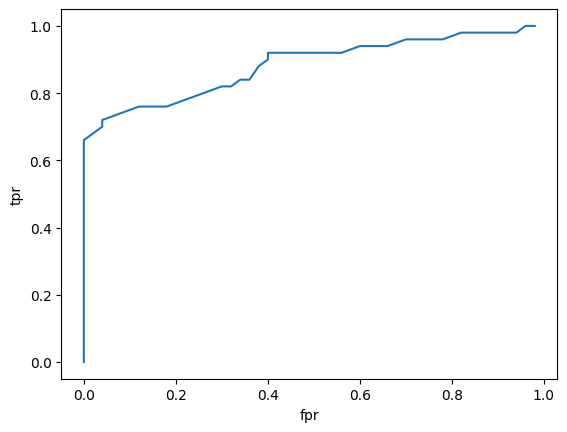

In [111]:
plt.plot(fpr_list, tpr_list)
plt.xlabel('fpr')
plt.ylabel('tpr')

In [114]:
print("th, fpr, tnr, tpr, fnr")
for z_th in [1.0, 2.0, 3.0, 4.0]:
  fpr = np.sum(z_score_ref > z_th) / len(z_score_ref)
  tnr = 1 - fpr
  tpr = np.sum(z_score_wm > z_th) / len(z_score_wm)
  fnr = 1 - tpr
  # print(f"th: {z_th}, fpr: {fpr:.4f}, tnr: {tnr:.4f}, tpr: {tpr:.4f}, fnr: {fnr:.4f}")
  print(f"{z_th}, {fpr:.4f}, {tnr:.4f}, {tpr:.4f}, {fnr:.4f}")

th, fpr, tnr, tpr, fnr
1.0, 0.2200, 0.7800, 0.7800, 0.2200
2.0, 0.0000, 1.0000, 0.6600, 0.3400
3.0, 0.0000, 1.0000, 0.5600, 0.4400
4.0, 0.0000, 1.0000, 0.4800, 0.5200
